# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
from numba import jit

# Parameters

In [3]:
nx = 50     # number of x-control volumes
ny = 50     # number of y-control volumes

x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

# Grid Generation

In [4]:
x = np.zeros([nx+2])    # 1 boundary node on each side
dx = (x_max-x_min)/nx   # cell-size in x-direction
dy = (y_max-y_min)/ny   # cell-size in y-direction

x[0] = x_min
x[-1] = x_max
x[1:-1] = np.arange(x_min+0.5*dx,x_max,dx)

y = np.copy(x)

In [5]:
X,Y = np.meshgrid(x,y)

# Simulation Parameters

In [6]:
β = 0.0       # Blending factor, 0 = upwind, 1 = linear interpolation
u_in = 2.0    # inlet velocity, x-component
v_in = 2.0    # inlet velocity, y-component
ρ = 1.0       # density
ϕ_west = 1.0  # ϕ values for inlet boundary condition (west)
ϕ_south = 0.0 # ϕ values for inlet boundary condition (south)

# Compute mass flow rate (in this case same for all faces and all cells)
mfr_east = ρ*u_in*dy
mfr_west = ρ*u_in*dy
mfr_north = ρ*v_in*dx
mfr_south = ρ*v_in*dx

# Initialise Arrays

In [7]:
ϕ = np.zeros([ny+2,nx+2])                      # initialise solution to zero
SU = np.zeros([ny+2,nx+2])                     # initialise SU (upwind)
SP = np.zeros([ny+2,nx+2])                     # initialise SP (upwind)
SUT = np.zeros([ny+2,nx+2])                    # initialise SUT (linear interpolation)
SPT = np.zeros([ny+2,nx+2])                    # initialise SPT (linear interpolation)
AE = np.zeros([ny+2,nx+2])                     # initialise AE (upwind)
AW = np.ones([ny+2,nx+2])*mfr_west             # initialise AW (upwind)
AN = np.zeros([ny+2,nx+2])                     # initialise AN (upwind)
AS = np.ones([ny+2,nx+2])*mfr_south            # initialise AS (upwind)
AET = np.ones([ny+2,nx+2])*(-0.5)*mfr_east     # initialise AE (linear interpolation)
AWT = np.ones([ny+2,nx+2])*(0.5)*mfr_west      # initialise AW (linear interpolation)
ANT = np.ones([ny+2,nx+2])*(-0.5)*mfr_north    # initialise AN (linear interpolation)
AST = np.ones([ny+2,nx+2])*(0.5)*mfr_south     # initialise AS (linear interpolation)

We need to set (overwrite) boundary conditions where necessary.

In [8]:
# West boundary
AW[:,1] = 0.0
AWT[:,1] = 0.0
SU[:,1] = mfr_west*ϕ_west
SUT[:,1] = mfr_west*ϕ_west
SP[:,1] = -mfr_east
SPT[:,1] = -mfr_east

# East boundary
AE[:,-2] = 0.0
AET[:,-2] = 0.0
SP[:,-2] = -(mfr_east-mfr_west)
SPT[:,-2] = -(mfr_east-mfr_west)

# South boundary
AS[1,:] = 0.0
AST[1,:] = 0.0
SU[1,:] = mfr_south*ϕ_south
SUT[1,:] = mfr_south*ϕ_south
SP[1,:] = -mfr_north
SPT[1,:] = -mfr_north

# North boundary
AN[-2,:] = 0.0
ANT[-2,:] = 0.0
SP[-2,:] = -(mfr_north-mfr_south)
SPT[-2,:] = -(mfr_north-mfr_south)

# South-West Corner Cell
AS[1,1] = 0.0
AW[1,1] = 0.0
AST[1,1] = 0.0
AWT[1,1] = 0.0
# next four lines determine west wall bc on southwest cell (i.e., ϕ_west=0 or 1)
# to set ϕ_west to 0 on west side of southwest cell
# SU[1,1] = mfr_west*0 + mfr_south*ϕ_south
#SUT[1,1] = mfr_west*0 + mfr_south*ϕ_south
# Otherwise, uncomment the lines below to set ϕ_west = 1 on the west side of southwest cell
SU[1,1] = mfr_west*ϕ_west + mfr_south*ϕ_south
SUT[1,1] = mfr_west*ϕ_west + mfr_south*ϕ_south
SP[1,1] = -mfr_east-mfr_north
SPT[1,1] = -mfr_east-mfr_north

# North-West corner
AN[-2,1] = 0.0
AW[-2,1] = 0.0
ANT[-2,1] = 0.0
AWT[-2,1] = 0.0
SU[-2,1] = mfr_west*ϕ_west
SUT[-2,1] = mfr_west*ϕ_west
SP[-2,1] = -mfr_east-(mfr_north-mfr_south)
SPT[-2,1] = -mfr_east-(mfr_north-mfr_south)

# South-East Corner
AS[1,-2] = 0.0
AE[1,-2] = 0.0
AST[1,-2] = 0.0
AET[1,-2] = 0.0
SP[1,-2] = -(mfr_east-mfr_west)-mfr_north
SPT[1,-2] = -(mfr_east-mfr_west)-mfr_north

# North-East corner
AN[-2,-2] = 0.0
AE[-2,-2] = 0.0
ANT[-2,-2] = 0.0
AET[-2,-2] = 0.0
SP[-2,-2] = -(mfr_east-mfr_west)-(mfr_north-mfr_south)
SPT[-2,-2] = -(mfr_east-mfr_west)-(mfr_north-mfr_south)

# Compute AP and APT
AP = AE+AW+AN+AS-SP
APT = AET+AWT+ANT+AST-SPT

# Iterative solution using deferred correction scheme

In [9]:
@jit(nopython=True)
def deferred_correction_scheme(ϕ,AE,AW,AN,AS,SU,SP,AET,AWT,ANT,AST,SUT,SPT,β=0.0,num_iter=100000):
    ϕ_new = np.zeros_like(ϕ)
    for n in range(num_iter): # Ensure enough iterations to converge
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                # insert \ for line continuation
                ϕ_new[j,i] = (AE[j,i]*ϕ[j,i+1]+AW[j,i]*ϕ[j,i-1]+AN[j,i]*ϕ[j+1,i]+AS[j,i]*ϕ[j-1,i]+SU[j,i])/AP[j,i] \
                - β/AP[j,i]*( (APT[j,i]*ϕ[j,i]-AET[j,i]*ϕ[j,i+1]-AWT[j,i]*ϕ[j,i-1]-ANT[j,i]*ϕ[j+1,i]
                               - AST[j,i]*ϕ[j-1,i]-SUT[j,i]) - (AP[j,i]*ϕ[j,i]-AE[j,i]*ϕ[j,i+1]-AW[j,i]*ϕ[j,i-1]
                                                                - AN[j,i]*ϕ[j+1,i]-AS[j,i]*ϕ[j-1,i] - SU[j,i]) )
        ϕ = ϕ_new
    return ϕ_new

# First Order Upwind

Ensure enough iterations for convergence.

In [10]:
β_upwind = 0.0
ϕ_upwind = deferred_correction_scheme(ϕ,AE,AW,AN,AS,SU,SP,AET,AWT,ANT,AST,SUT,SPT,β_upwind)

#### Visualization

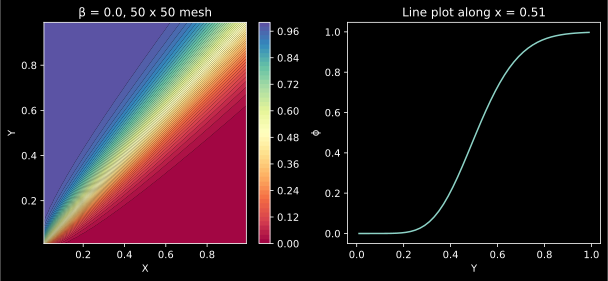

In [11]:
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X[1:-1,1:-1],Y[1:-1,1:-1],ϕ_upwind[1:-1,1:-1],cmap='Spectral',levels=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title(f'β = {β_upwind}, {nx} x {ny} mesh')

plt.subplot(1,2,2)
plt.plot(y[1:-1],ϕ_upwind[1:-1,int(nx/2+1)])
#plt.legend(['ϕ'])
plt.xlabel('Y')
plt.ylabel('ϕ')
plt.title(f'Line plot along x = {x[int(nx/2+1)]:.2f}');

# Second Order Central (Linear Interpolation)

In [12]:
ϕ = np.zeros([ny+2,nx+2])                      # initialise solution to zero
β_central = 1.0
num_iter_cd = 10000
ϕ_central = deferred_correction_scheme(ϕ,AE,AW,AN,AS,SU,SP,AET,AWT,ANT,AST,SUT,SPT,β_central,num_iter_cd)

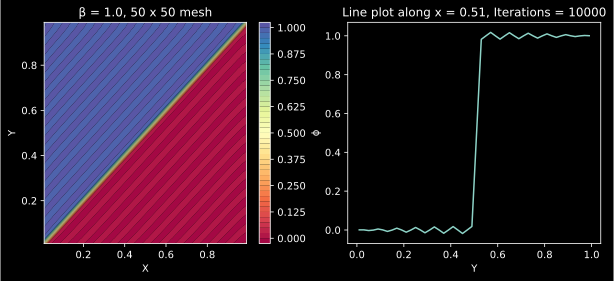

In [13]:
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X[1:-1,1:-1],Y[1:-1,1:-1],ϕ_central[1:-1,1:-1],cmap='Spectral',levels=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title(f'β = {β_central}, {nx} x {ny} mesh')

plt.subplot(1,2,2)
plt.plot(y[1:-1],ϕ_central[1:-1,int(nx/2+1)])
#plt.legend(['ϕ'])
plt.xlabel('Y')
plt.ylabel('ϕ')
plt.title(f'Line plot along x = {x[int(nx/2+1)]:.2f}, Iterations = {num_iter_cd}');

In [14]:
ϕ = np.zeros([ny+2,nx+2])                      # initialise solution to zero
β_central = 1.0
num_iter_cd = 100000
ϕ_central = deferred_correction_scheme(ϕ,AE,AW,AN,AS,SU,SP,AET,AWT,ANT,AST,SUT,SPT,β_central,num_iter_cd)

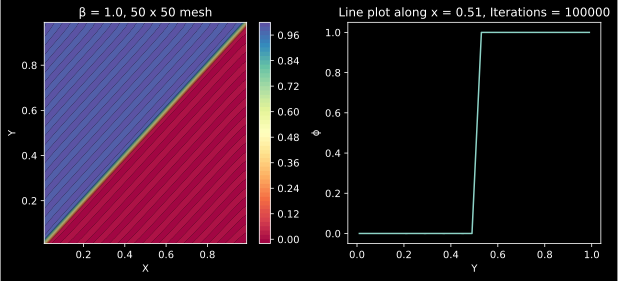

In [15]:
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X[1:-1,1:-1],Y[1:-1,1:-1],ϕ_central[1:-1,1:-1],cmap='Spectral',levels=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title(f'β = {β_central}, {nx} x {ny} mesh')

plt.subplot(1,2,2)
plt.plot(y[1:-1],ϕ_central[1:-1,int(nx/2+1)])
#plt.legend(['ϕ'])
plt.xlabel('Y')
plt.ylabel('ϕ')
plt.title(f'Line plot along x = {x[int(nx/2+1)]:.2f}, Iterations = {num_iter_cd}');

# Blended Solution, $\beta = 0.9$

In [16]:
ϕ = np.zeros([ny+2,nx+2])                      # initialise solution to zero
β = 0.9
num_iter_blend = 100000
ϕ_blended = deferred_correction_scheme(ϕ,AE,AW,AN,AS,SU,SP,AET,AWT,ANT,AST,SUT,SPT,β,num_iter_blend)

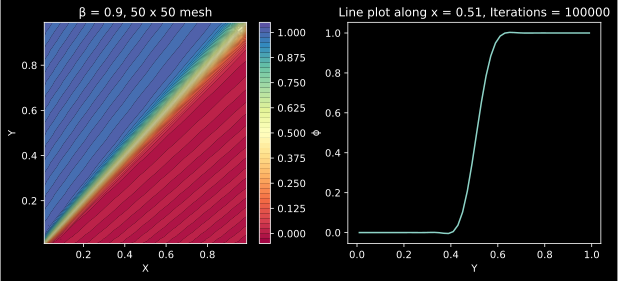

In [17]:
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X[1:-1,1:-1],Y[1:-1,1:-1],ϕ_blended[1:-1,1:-1],cmap='Spectral',levels=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title(f'β = {β}, {nx} x {ny} mesh')

plt.subplot(1,2,2)
plt.plot(y[1:-1],ϕ_blended[1:-1,int(nx/2+1)])
#plt.legend(['ϕ'])
plt.xlabel('Y')
plt.ylabel('ϕ')
plt.title(f'Line plot along x = {x[int(nx/2+1)]:.2f}, Iterations = {num_iter_blend}');

# Note on Blending factor

**Let us take a moment to reflect on what we learned from this exercise**

What was the effect of the blending factor on the solution?

Increasing the blending factor from zero toward one significantly decreased the level of artificial diffusion, or smearing of the discontinuity, in the result.  Increasing to one, depending on the arrangement of the left boundary condition, resulted in non-physical oscillations in the solutions.